# Carga de las librerías

Importación de las librerías que se van a usar

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import optuna
import joblib

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from optuna.integration import TFKerasPruningCallback

pd.options.mode.chained_assignment = None

# Carga de los datos

Carga de los ficheros de datos generados en con el script.
Los datos de Santo Domingo están en pesos dominicanos, así que se aplica un factor de conversión a las ventas para mostrar los datos en euros.
Fusión de cada dataset con los datos diarios de la temperatura obtenidos de https://meteostat.net/es/

In [2]:
markets = ['market_1', 'market_2', 'market_3', 'market_4', 'market_5', 'market_6']
dfs = {f'{key}': pd.read_csv(f'data/{key}_sales.csv') for key in markets}

In [3]:
for df_name, df in dfs.items():
    if df_name == 'market_5':
        df['sales'] *= 0.016
    if df_name == 'market_6':
        df['sales'] *= 0.9
    df = df.copy()
    
    df_weather = pd.read_csv('data/{}_weather.csv'.format(df_name), usecols=['date', 'tavg'])
    
    df = pd.merge(df, df_weather, on='date', how='left')
    dfs[df_name] = df

In [4]:
dfs['market_5'].head()

,date,store_type,sales,discount_average,has_new_product,is_weekend,market,tavg
0,2021-01-02,type_3,238.30256,10.0,0,1,market_5,23.8
1,2021-01-02,type_2,62.42992,10.0,1,1,market_5,23.8
2,2021-01-03,type_3,322.97056,10.0,0,1,market_5,24.6
3,2021-01-03,type_2,110.79024,10.0,1,1,market_5,24.6
4,2021-01-04,type_3,2732.44448,10.0,0,0,market_5,24.8


Descripción de los campos:
* date: fecha
* store_type: tipo de explotación
* sales: ventas
* discount_average: descuento medio de los productos con descuento
* has_new_product: indica si se está vendiendo un producto nuevo
* is_weekend: indica si es viernes, sábado o domingo
* market: el mercado físico
* tavg: temperatura media (Celsius)

Tenemos entonces un total de 6 datasets sobre los que trabajaremos, cada uno contiene datos para cada mercado (gca: Gran Canaria, tfe: Tenerife, pmi: Palma de Mallorca, lzt: Lanzarote, sdq: Santo Domingo, pur: Puerto Rico)

# Limpieza de los datos

Revisión de la carga de los datos verificando el tipo de dato de cada columna y la presencia de valores nulos y su posterior tratamiento.

In [5]:
for df_name, df in dfs.items():
    print('The {} dataframe shape is: {}'.format(df_name, df.shape))

The market_1 dataframe shape is: (2942, 8)
The market_2 dataframe shape is: (2948, 8)
The market_3 dataframe shape is: (2964, 8)
The market_4 dataframe shape is: (1956, 8)
The market_5 dataframe shape is: (3517, 8)
The market_6 dataframe shape is: (2680, 8)


In [6]:
for df_name, df in dfs.items():
    print('Data type per column from {} dataframe:'.format(df_name))
    print(df.dtypes, '\n')

Data type per column from market_1 dataframe:
date                 object
store_type           object
sales               float64
discount_average    float64
has_new_product       int64
is_weekend            int64
market               object
tavg                float64
dtype: object 

Data type per column from market_2 dataframe:
date                 object
store_type           object
sales               float64
discount_average    float64
has_new_product       int64
is_weekend            int64
market               object
tavg                float64
dtype: object 

Data type per column from market_3 dataframe:
date                 object
store_type           object
sales               float64
discount_average    float64
has_new_product       int64
is_weekend            int64
market               object
tavg                float64
dtype: object 

Data type per column from market_4 dataframe:
date                 object
store_type           object
sales               float64
discount_ave

In [7]:
for df_name, df in dfs.items():
    print('Nan values per column from {} dataframe:'.format(df_name))
    print(df.isna().sum())
    print()

Nan values per column from market_1 dataframe:
date                 0
store_type           0
sales                0
discount_average    17
has_new_product      0
is_weekend           0
market               0
tavg                 0
dtype: int64

Nan values per column from market_2 dataframe:
date                 0
store_type           0
sales                0
discount_average    48
has_new_product      0
is_weekend           0
market               0
tavg                 0
dtype: int64

Nan values per column from market_3 dataframe:
date                 0
store_type           0
sales                0
discount_average    11
has_new_product      0
is_weekend           0
market               0
tavg                 0
dtype: int64

Nan values per column from market_4 dataframe:
date                0
store_type          0
sales               0
discount_average    0
has_new_product     0
is_weekend          0
market              0
tavg                0
dtype: int64

Nan values per column from m

Hay presencia de valores faltantes para el desuento medio (`discount_average`). Se reemplazan los valores faltantes por el valor de la media del descuento medio de la explotación a la que pertenece el registro.

In [8]:
for df_name, df in dfs.items():
    mean_values = df.groupby('store_type')['discount_average'].transform('mean')
    df['discount_average'] = df['discount_average'].fillna(mean_values)
    dfs[df_name] = df

# Guardado de  datos preprocesados

In [9]:
for df_name, df in dfs.items():
    df.to_csv(f'data/{df_name}_prep.csv', index=False)

# Diseño de la red neuronal recurrente (RNN)

In [10]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)


In [11]:

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=trial.suggest_int('units_1', 10, 100), return_sequences=True))
    model.add(Dropout(trial.suggest_float('dropout', 0.2, 0.5)))
    model.add(LSTM(units=trial.suggest_int('units_2', 10, 100), return_sequences=True))
    model.add(Dropout(trial.suggest_float('dropout', 0.2, 0.5)))
    model.add(LSTM(units=trial.suggest_int('units_3', 10, 100)))
    model.add(Dropout(trial.suggest_float('dropout', 0.2, 0.5)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-1)), loss="mean_squared_error")
    return model




In [12]:
def objective(trial, trainX, trainY, valX, valY):
    input_shape = (trainX.shape[1], trainX.shape[2])
    model = create_model(trial, input_shape)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(valX, valY), callbacks=[early_stopping], verbose=0)
    
    val_loss = min(history.history['val_loss'])
    return val_loss

# Selección de hiperparámetros

In [13]:
best_params = []


for df_name, df in dfs.items():
    
    for store_type in ['type_1', 'type_2', 'type_3']:
        
        df_study = df[df['store_type'] == store_type]
        
        if len(df_study) > 0:
        
            df_study.drop(['store_type', 'market'], axis=1, inplace=True)

            df_study['date'] = pd.to_datetime(df_study['date'])
            df_study.set_index('date', inplace=True)


            scaler = MinMaxScaler(feature_range=(0, 1))
            df_scaled = scaler.fit_transform(df_study)

            train_size = int(len(df_study) * 0.7)
            val_size = int(len(df_study) * 0.15)

            train = df_scaled[:train_size]
            val = df_scaled[train_size:train_size + val_size]
            test = df_scaled[train_size + val_size:]

            trainX, trainY = createXY(train, 30)
            valX, valY = createXY(val, 30)

            study = optuna.create_study(direction='minimize')
            study.optimize(lambda trial: objective(trial, trainX, trainY, valX, valY), n_trials=50, timeout=600)

            best_params.append(study.best_params)

            # Guardar los mejores hiperparámetros
            with open(f'models/{df_name}/best_params_store_{df_name}_{store_type}.json', 'w') as f:
                json.dump(study.best_params, f)

[I 2024-06-12 19:04:54,146] A new study created in memory with name: no-name-f1633f7c-d717-44cf-95ea-949bfdc288e3
[I 2024-06-12 19:05:01,982] Trial 0 finished with value: 0.01469003688544035 and parameters: {'units_1': 51, 'dropout': 0.4335681338082762, 'units_2': 40, 'units_3': 39, 'learning_rate': 0.01588128087584545}. Best is trial 0 with value: 0.01469003688544035.
[I 2024-06-12 19:05:07,685] Trial 1 finished with value: 0.07916399091482162 and parameters: {'units_1': 15, 'dropout': 0.252060063495609, 'units_2': 68, 'units_3': 28, 'learning_rate': 0.05291507130361295}. Best is trial 0 with value: 0.01469003688544035.
[I 2024-06-12 19:05:20,382] Trial 2 finished with value: 0.0594666451215744 and parameters: {'units_1': 95, 'dropout': 0.46049354074305154, 'units_2': 85, 'units_3': 94, 'learning_rate': 0.08646874514606138}. Best is trial 0 with value: 0.01469003688544035.
[I 2024-06-12 19:05:25,911] Trial 3 finished with value: 0.022977668792009354 and parameters: {'units_1': 43, 'dr

[I 2024-06-12 19:09:48,091] Trial 31 finished with value: 0.01482683140784502 and parameters: {'units_1': 85, 'dropout': 0.21947220083784988, 'units_2': 72, 'units_3': 54, 'learning_rate': 0.009205507098218803}. Best is trial 24 with value: 0.009653071872889996.
[I 2024-06-12 19:09:53,548] Trial 32 finished with value: 0.026872867718338966 and parameters: {'units_1': 91, 'dropout': 0.24535183623141976, 'units_2': 82, 'units_3': 58, 'learning_rate': 0.019758996590451633}. Best is trial 24 with value: 0.009653071872889996.
[I 2024-06-12 19:10:02,630] Trial 33 finished with value: 0.016584988683462143 and parameters: {'units_1': 79, 'dropout': 0.3365566772694792, 'units_2': 65, 'units_3': 72, 'learning_rate': 0.020952180909602887}. Best is trial 24 with value: 0.009653071872889996.
[I 2024-06-12 19:10:09,975] Trial 34 finished with value: 0.018952978774905205 and parameters: {'units_1': 72, 'dropout': 0.30957165138886955, 'units_2': 91, 'units_3': 57, 'learning_rate': 0.000386979258133824

[I 2024-06-12 19:13:51,398] Trial 12 finished with value: 0.012606344185769558 and parameters: {'units_1': 45, 'dropout': 0.4990396034475413, 'units_2': 77, 'units_3': 36, 'learning_rate': 0.001499689517576495}. Best is trial 8 with value: 0.01171165145933628.
[I 2024-06-12 19:13:58,287] Trial 13 finished with value: 0.012522991746664047 and parameters: {'units_1': 36, 'dropout': 0.42724009079145875, 'units_2': 75, 'units_3': 57, 'learning_rate': 0.02109217501851843}. Best is trial 8 with value: 0.01171165145933628.
[I 2024-06-12 19:14:05,376] Trial 14 finished with value: 0.01218343060463667 and parameters: {'units_1': 10, 'dropout': 0.45158834923971897, 'units_2': 82, 'units_3': 15, 'learning_rate': 0.0231302485367693}. Best is trial 8 with value: 0.01171165145933628.
[I 2024-06-12 19:14:10,745] Trial 15 finished with value: 0.013297831639647484 and parameters: {'units_1': 52, 'dropout': 0.4316512263706119, 'units_2': 79, 'units_3': 10, 'learning_rate': 0.02509230728736221}. Best is 

[I 2024-06-12 19:18:09,963] Trial 44 finished with value: 0.01277934294193983 and parameters: {'units_1': 26, 'dropout': 0.20222538546833504, 'units_2': 88, 'units_3': 21, 'learning_rate': 0.006029237898695949}. Best is trial 24 with value: 0.008240156807005405.
[I 2024-06-12 19:18:15,737] Trial 45 finished with value: 0.013359755277633667 and parameters: {'units_1': 21, 'dropout': 0.22641613843616498, 'units_2': 80, 'units_3': 40, 'learning_rate': 0.05028172022380411}. Best is trial 24 with value: 0.008240156807005405.
[I 2024-06-12 19:18:22,700] Trial 46 finished with value: 0.012458398938179016 and parameters: {'units_1': 12, 'dropout': 0.35878524309937243, 'units_2': 84, 'units_3': 26, 'learning_rate': 0.020595359289100692}. Best is trial 24 with value: 0.008240156807005405.
[I 2024-06-12 19:18:31,495] Trial 47 finished with value: 0.013410549610853195 and parameters: {'units_1': 85, 'dropout': 0.3229672278300201, 'units_2': 75, 'units_3': 20, 'learning_rate': 0.026181731846987185}

[I 2024-06-12 19:24:48,554] Trial 25 finished with value: 0.01941036432981491 and parameters: {'units_1': 59, 'dropout': 0.2736110952140284, 'units_2': 44, 'units_3': 85, 'learning_rate': 0.036463013514673445}. Best is trial 20 with value: 0.00546478433534503.
[I 2024-06-12 19:25:02,901] Trial 26 finished with value: 0.011791120283305645 and parameters: {'units_1': 76, 'dropout': 0.3887303905846591, 'units_2': 64, 'units_3': 76, 'learning_rate': 0.022938098927924356}. Best is trial 20 with value: 0.00546478433534503.
[I 2024-06-12 19:25:29,300] Trial 27 finished with value: 0.007622782606631517 and parameters: {'units_1': 87, 'dropout': 0.32848072851870935, 'units_2': 18, 'units_3': 91, 'learning_rate': 0.008854645879680366}. Best is trial 20 with value: 0.00546478433534503.
[I 2024-06-12 19:25:57,632] Trial 28 finished with value: 0.006155871786177158 and parameters: {'units_1': 64, 'dropout': 0.27821364352500955, 'units_2': 32, 'units_3': 74, 'learning_rate': 0.007959421046517808}. B

[I 2024-06-12 19:31:12,727] Trial 10 finished with value: 0.012707719579339027 and parameters: {'units_1': 13, 'dropout': 0.3074520105849299, 'units_2': 61, 'units_3': 13, 'learning_rate': 0.03497703757664476}. Best is trial 3 with value: 0.009942877106368542.
[I 2024-06-12 19:31:19,202] Trial 11 finished with value: 0.015925901010632515 and parameters: {'units_1': 13, 'dropout': 0.2883725696486628, 'units_2': 39, 'units_3': 10, 'learning_rate': 0.0018738439851049699}. Best is trial 3 with value: 0.009942877106368542.
[I 2024-06-12 19:31:34,332] Trial 12 finished with value: 0.009370461106300354 and parameters: {'units_1': 33, 'dropout': 0.3383000744316999, 'units_2': 34, 'units_3': 27, 'learning_rate': 0.021070857813759763}. Best is trial 12 with value: 0.009370461106300354.
[I 2024-06-12 19:31:43,673] Trial 13 finished with value: 0.010024040006101131 and parameters: {'units_1': 31, 'dropout': 0.3469236212606563, 'units_2': 24, 'units_3': 26, 'learning_rate': 0.02507540269821036}. Be

[I 2024-06-12 19:36:54,791] Trial 42 finished with value: 0.04757675155997276 and parameters: {'units_1': 27, 'dropout': 0.2309787452089788, 'units_2': 60, 'units_3': 32, 'learning_rate': 0.07400242659169382}. Best is trial 34 with value: 0.007679044734686613.
[I 2024-06-12 19:37:14,150] Trial 43 finished with value: 0.007406243123114109 and parameters: {'units_1': 14, 'dropout': 0.212462376763668, 'units_2': 48, 'units_3': 45, 'learning_rate': 0.02019747906295778}. Best is trial 43 with value: 0.007406243123114109.
[I 2024-06-12 19:37:26,836] Trial 44 finished with value: 0.015576704405248165 and parameters: {'units_1': 92, 'dropout': 0.21598448523818292, 'units_2': 77, 'units_3': 44, 'learning_rate': 0.018748597674110436}. Best is trial 43 with value: 0.007406243123114109.
[I 2024-06-12 19:37:42,277] Trial 45 finished with value: 0.0088003845885396 and parameters: {'units_1': 13, 'dropout': 0.26918259875118455, 'units_2': 66, 'units_3': 37, 'learning_rate': 0.005862571667629296}. Bes

[I 2024-06-12 19:42:33,029] Trial 23 finished with value: 0.03873984515666962 and parameters: {'units_1': 55, 'dropout': 0.45107269883377865, 'units_2': 78, 'units_3': 31, 'learning_rate': 0.024572495698446897}. Best is trial 15 with value: 0.007291846442967653.
[I 2024-06-12 19:42:38,523] Trial 24 finished with value: 0.021098142489790916 and parameters: {'units_1': 65, 'dropout': 0.38938505184832256, 'units_2': 27, 'units_3': 47, 'learning_rate': 0.0391937473837328}. Best is trial 15 with value: 0.007291846442967653.
[I 2024-06-12 19:42:46,099] Trial 25 finished with value: 0.009781886823475361 and parameters: {'units_1': 31, 'dropout': 0.49959965002750373, 'units_2': 37, 'units_3': 64, 'learning_rate': 0.011746534817425037}. Best is trial 15 with value: 0.007291846442967653.
[I 2024-06-12 19:42:53,521] Trial 26 finished with value: 0.0385943166911602 and parameters: {'units_1': 41, 'dropout': 0.3555885032632421, 'units_2': 91, 'units_3': 15, 'learning_rate': 0.05188426854410314}. Be

[I 2024-06-12 19:47:39,373] Trial 4 finished with value: 0.023426521569490433 and parameters: {'units_1': 58, 'dropout': 0.21358611225872953, 'units_2': 99, 'units_3': 67, 'learning_rate': 0.04108940289946883}. Best is trial 3 with value: 0.008618416264653206.
[I 2024-06-12 19:47:55,077] Trial 5 finished with value: 0.027406712993979454 and parameters: {'units_1': 86, 'dropout': 0.4776561678088793, 'units_2': 100, 'units_3': 45, 'learning_rate': 0.05688815911721674}. Best is trial 3 with value: 0.008618416264653206.
[I 2024-06-12 19:48:04,116] Trial 6 finished with value: 0.028313204646110535 and parameters: {'units_1': 13, 'dropout': 0.3298348888333288, 'units_2': 17, 'units_3': 33, 'learning_rate': 0.0787940052938614}. Best is trial 3 with value: 0.008618416264653206.
[I 2024-06-12 19:48:14,223] Trial 7 finished with value: 0.02754995971918106 and parameters: {'units_1': 46, 'dropout': 0.47529468289645543, 'units_2': 35, 'units_3': 89, 'learning_rate': 0.06907931609865228}. Best is t

[I 2024-06-12 19:53:27,549] Trial 36 finished with value: 0.02927699126303196 and parameters: {'units_1': 58, 'dropout': 0.3347733888582905, 'units_2': 23, 'units_3': 38, 'learning_rate': 0.02938074093396594}. Best is trial 3 with value: 0.008618416264653206.
[I 2024-06-12 19:53:42,486] Trial 37 finished with value: 0.009445445612072945 and parameters: {'units_1': 41, 'dropout': 0.46246422443810875, 'units_2': 16, 'units_3': 63, 'learning_rate': 0.012229155081711943}. Best is trial 3 with value: 0.008618416264653206.
[I 2024-06-12 19:53:53,392] Trial 38 finished with value: 0.010460540652275085 and parameters: {'units_1': 32, 'dropout': 0.4871148311647521, 'units_2': 16, 'units_3': 64, 'learning_rate': 0.006878038996599522}. Best is trial 3 with value: 0.008618416264653206.
[I 2024-06-12 19:53:58,739] Trial 39 finished with value: 0.0268342774361372 and parameters: {'units_1': 25, 'dropout': 0.4617480728200569, 'units_2': 15, 'units_3': 63, 'learning_rate': 0.025520692737189835}. Best 

[I 2024-06-12 19:59:57,934] Trial 17 finished with value: 0.03313886374235153 and parameters: {'units_1': 63, 'dropout': 0.2745153501398947, 'units_2': 61, 'units_3': 73, 'learning_rate': 0.034368470466832265}. Best is trial 3 with value: 0.005175220314413309.
[I 2024-06-12 20:00:03,696] Trial 18 finished with value: 0.041388195008039474 and parameters: {'units_1': 24, 'dropout': 0.411097840903038, 'units_2': 35, 'units_3': 21, 'learning_rate': 0.07209451542957244}. Best is trial 3 with value: 0.005175220314413309.
[I 2024-06-12 20:00:24,347] Trial 19 finished with value: 0.007160371635109186 and parameters: {'units_1': 99, 'dropout': 0.27671928777576227, 'units_2': 43, 'units_3': 36, 'learning_rate': 0.009906734398915894}. Best is trial 3 with value: 0.005175220314413309.
[I 2024-06-12 20:00:33,154] Trial 20 finished with value: 0.04262596368789673 and parameters: {'units_1': 29, 'dropout': 0.35102757846027516, 'units_2': 86, 'units_3': 51, 'learning_rate': 0.05987497494967092}. Best 

[I 2024-06-12 20:05:51,537] Trial 0 finished with value: 0.005890209227800369 and parameters: {'units_1': 60, 'dropout': 0.2236207640645489, 'units_2': 88, 'units_3': 17, 'learning_rate': 0.05490306603155154}. Best is trial 0 with value: 0.005890209227800369.
[I 2024-06-12 20:06:03,262] Trial 1 finished with value: 0.005887721665203571 and parameters: {'units_1': 69, 'dropout': 0.3826783486784475, 'units_2': 63, 'units_3': 10, 'learning_rate': 0.08307631360445704}. Best is trial 1 with value: 0.005887721665203571.
[I 2024-06-12 20:06:17,408] Trial 2 finished with value: 0.005889071151614189 and parameters: {'units_1': 70, 'dropout': 0.2956877225547815, 'units_2': 75, 'units_3': 53, 'learning_rate': 0.03841938017592694}. Best is trial 1 with value: 0.005887721665203571.
[I 2024-06-12 20:06:25,698] Trial 3 finished with value: 0.005906452424824238 and parameters: {'units_1': 96, 'dropout': 0.4350373785967656, 'units_2': 96, 'units_3': 66, 'learning_rate': 0.07077594950958085}. Best is tr

[I 2024-06-12 20:11:11,410] Trial 32 finished with value: 0.005888677667826414 and parameters: {'units_1': 34, 'dropout': 0.2981643534632508, 'units_2': 25, 'units_3': 40, 'learning_rate': 0.04847535146148873}. Best is trial 31 with value: 0.005817179102450609.
[I 2024-06-12 20:11:18,294] Trial 33 finished with value: 0.0058809746988117695 and parameters: {'units_1': 58, 'dropout': 0.2749737960521533, 'units_2': 41, 'units_3': 17, 'learning_rate': 0.041298507204819854}. Best is trial 31 with value: 0.005817179102450609.
[I 2024-06-12 20:11:39,461] Trial 34 finished with value: 0.005888784304261208 and parameters: {'units_1': 69, 'dropout': 0.2719621180019901, 'units_2': 57, 'units_3': 11, 'learning_rate': 0.04080537323500546}. Best is trial 31 with value: 0.005817179102450609.
[I 2024-06-12 20:11:47,475] Trial 35 finished with value: 0.005835818592458963 and parameters: {'units_1': 57, 'dropout': 0.36997166426684847, 'units_2': 41, 'units_3': 23, 'learning_rate': 0.027085207331211753}.

[I 2024-06-12 20:15:50,652] Trial 13 finished with value: 0.007622554898262024 and parameters: {'units_1': 32, 'dropout': 0.4916888608558677, 'units_2': 30, 'units_3': 49, 'learning_rate': 0.01676772605559685}. Best is trial 11 with value: 0.006351119838654995.
[I 2024-06-12 20:15:57,090] Trial 14 finished with value: 0.008439515717327595 and parameters: {'units_1': 59, 'dropout': 0.32129533396679927, 'units_2': 60, 'units_3': 71, 'learning_rate': 0.0010156559564918532}. Best is trial 11 with value: 0.006351119838654995.
[I 2024-06-12 20:16:04,535] Trial 15 finished with value: 0.007635056506842375 and parameters: {'units_1': 43, 'dropout': 0.2501951870422065, 'units_2': 31, 'units_3': 71, 'learning_rate': 0.022965398195837622}. Best is trial 11 with value: 0.006351119838654995.
[I 2024-06-12 20:16:12,047] Trial 16 finished with value: 0.024958651512861252 and parameters: {'units_1': 57, 'dropout': 0.26711541845390774, 'units_2': 50, 'units_3': 50, 'learning_rate': 0.043210739388373456

[I 2024-06-12 20:21:22,078] Trial 45 finished with value: 0.006952531635761261 and parameters: {'units_1': 68, 'dropout': 0.35928026707683314, 'units_2': 72, 'units_3': 66, 'learning_rate': 0.0039866787484943095}. Best is trial 29 with value: 0.00610182574018836.
[I 2024-06-12 20:21:35,443] Trial 46 finished with value: 0.024152284488081932 and parameters: {'units_1': 77, 'dropout': 0.2805379697593859, 'units_2': 33, 'units_3': 60, 'learning_rate': 0.029159719059258446}. Best is trial 29 with value: 0.00610182574018836.
[I 2024-06-12 20:21:45,132] Trial 47 finished with value: 0.017740361392498016 and parameters: {'units_1': 54, 'dropout': 0.20232805296163298, 'units_2': 42, 'units_3': 51, 'learning_rate': 0.022055850458801023}. Best is trial 29 with value: 0.00610182574018836.
[I 2024-06-12 20:22:03,870] Trial 48 finished with value: 0.0066331177949905396 and parameters: {'units_1': 46, 'dropout': 0.3077798888581438, 'units_2': 60, 'units_3': 74, 'learning_rate': 0.015771368601232533}

[I 2024-06-12 20:29:16,325] Trial 26 finished with value: 0.007053069770336151 and parameters: {'units_1': 91, 'dropout': 0.4216860235820816, 'units_2': 36, 'units_3': 16, 'learning_rate': 0.01120162123019115}. Best is trial 26 with value: 0.007053069770336151.
[I 2024-06-12 20:29:31,908] Trial 27 finished with value: 0.010397261008620262 and parameters: {'units_1': 92, 'dropout': 0.4217413007757116, 'units_2': 38, 'units_3': 18, 'learning_rate': 0.01792589573974155}. Best is trial 26 with value: 0.007053069770336151.
[I 2024-06-12 20:29:44,334] Trial 28 finished with value: 0.030645819380879402 and parameters: {'units_1': 92, 'dropout': 0.4635422034053101, 'units_2': 31, 'units_3': 13, 'learning_rate': 0.039565408345025525}. Best is trial 26 with value: 0.007053069770336151.
[I 2024-06-12 20:29:52,043] Trial 29 finished with value: 0.028741126880049706 and parameters: {'units_1': 67, 'dropout': 0.44078267548052497, 'units_2': 18, 'units_3': 22, 'learning_rate': 0.05528418566717801}. B

[I 2024-06-12 20:35:28,548] Trial 15 finished with value: 0.0048636505380272865 and parameters: {'units_1': 76, 'dropout': 0.43721680890876047, 'units_2': 48, 'units_3': 40, 'learning_rate': 0.0186884231583416}. Best is trial 11 with value: 0.004830604884773493.
[I 2024-06-12 20:35:38,402] Trial 16 finished with value: 0.004882541485130787 and parameters: {'units_1': 22, 'dropout': 0.2796058476025166, 'units_2': 73, 'units_3': 40, 'learning_rate': 0.02334408184676259}. Best is trial 11 with value: 0.004830604884773493.
[I 2024-06-12 20:35:52,747] Trial 17 finished with value: 0.005430204328149557 and parameters: {'units_1': 41, 'dropout': 0.3454493335454491, 'units_2': 92, 'units_3': 67, 'learning_rate': 0.09832402706500415}. Best is trial 11 with value: 0.004830604884773493.
[I 2024-06-12 20:36:03,865] Trial 18 finished with value: 0.0072161550633609295 and parameters: {'units_1': 11, 'dropout': 0.4990163543640085, 'units_2': 41, 'units_3': 100, 'learning_rate': 0.04653892610562332}. 

[I 2024-06-12 20:42:59,231] Trial 47 finished with value: 0.005603356286883354 and parameters: {'units_1': 37, 'dropout': 0.3099477045071821, 'units_2': 96, 'units_3': 80, 'learning_rate': 0.032082319981219375}. Best is trial 46 with value: 0.004827025346457958.
[I 2024-06-12 20:42:59,242] A new study created in memory with name: no-name-2cb89924-96d1-4d7d-b43b-f6b8a30a6c91
[I 2024-06-12 20:43:16,177] Trial 0 finished with value: 0.037032682448625565 and parameters: {'units_1': 74, 'dropout': 0.23256660955737868, 'units_2': 28, 'units_3': 46, 'learning_rate': 0.029145404550598494}. Best is trial 0 with value: 0.037032682448625565.
[I 2024-06-12 20:43:28,278] Trial 1 finished with value: 0.03702014684677124 and parameters: {'units_1': 71, 'dropout': 0.3180621709891652, 'units_2': 18, 'units_3': 16, 'learning_rate': 0.07041362071111092}. Best is trial 1 with value: 0.03702014684677124.
[I 2024-06-12 20:43:41,758] Trial 2 finished with value: 0.03705515339970589 and parameters: {'units_1'

[I 2024-06-12 20:54:42,728] Trial 4 finished with value: 0.005753314588218927 and parameters: {'units_1': 46, 'dropout': 0.37061865232923163, 'units_2': 23, 'units_3': 81, 'learning_rate': 0.08304368477480382}. Best is trial 3 with value: 0.0055246371775865555.
[I 2024-06-12 20:54:56,124] Trial 5 finished with value: 0.005740800406783819 and parameters: {'units_1': 77, 'dropout': 0.2434091532684458, 'units_2': 55, 'units_3': 95, 'learning_rate': 0.09424038798022728}. Best is trial 3 with value: 0.0055246371775865555.
[I 2024-06-12 20:55:41,839] Trial 6 finished with value: 0.0044447267428040504 and parameters: {'units_1': 11, 'dropout': 0.45394956569688805, 'units_2': 88, 'units_3': 69, 'learning_rate': 0.0013912043363981438}. Best is trial 6 with value: 0.0044447267428040504.
[I 2024-06-12 20:55:57,174] Trial 7 finished with value: 0.005725241266191006 and parameters: {'units_1': 92, 'dropout': 0.327331602673115, 'units_2': 75, 'units_3': 29, 'learning_rate': 0.031124703836078824}. Be

[I 2024-06-12 21:07:57,574] Trial 9 finished with value: 0.011762118898332119 and parameters: {'units_1': 32, 'dropout': 0.4537374273660289, 'units_2': 45, 'units_3': 32, 'learning_rate': 0.07119300211185245}. Best is trial 4 with value: 0.00201608007773757.
[I 2024-06-12 21:08:33,849] Trial 10 finished with value: 0.003925477620214224 and parameters: {'units_1': 41, 'dropout': 0.31367490478684734, 'units_2': 38, 'units_3': 52, 'learning_rate': 0.04168504732336678}. Best is trial 4 with value: 0.00201608007773757.
[I 2024-06-12 21:08:44,759] Trial 11 finished with value: 0.01201363280415535 and parameters: {'units_1': 57, 'dropout': 0.31943009652034826, 'units_2': 33, 'units_3': 13, 'learning_rate': 0.04740682787111824}. Best is trial 4 with value: 0.00201608007773757.
[I 2024-06-12 21:08:58,259] Trial 12 finished with value: 0.011819807812571526 and parameters: {'units_1': 74, 'dropout': 0.3272376635579211, 'units_2': 28, 'units_3': 47, 'learning_rate': 0.06681427517729092}. Best is t

[I 2024-06-12 21:18:21,165] Trial 11 finished with value: 0.0059964535757899284 and parameters: {'units_1': 15, 'dropout': 0.48856777277814045, 'units_2': 10, 'units_3': 12, 'learning_rate': 0.028154463368155334}. Best is trial 9 with value: 0.005517876707017422.
[I 2024-06-12 21:18:42,200] Trial 12 finished with value: 0.005629422143101692 and parameters: {'units_1': 32, 'dropout': 0.22426358839848642, 'units_2': 29, 'units_3': 26, 'learning_rate': 0.01991018325502178}. Best is trial 9 with value: 0.005517876707017422.
[I 2024-06-12 21:18:55,025] Trial 13 finished with value: 0.006292605772614479 and parameters: {'units_1': 64, 'dropout': 0.273714367110447, 'units_2': 30, 'units_3': 30, 'learning_rate': 0.019352775209163637}. Best is trial 9 with value: 0.005517876707017422.
[I 2024-06-12 21:19:15,332] Trial 14 finished with value: 0.020578639581799507 and parameters: {'units_1': 99, 'dropout': 0.2004280624668855, 'units_2': 26, 'units_3': 80, 'learning_rate': 0.06373547690412762}. Be

[I 2024-06-12 21:38:21,963] Trial 4 finished with value: 0.006179402116686106 and parameters: {'units_1': 26, 'dropout': 0.36127089380250194, 'units_2': 84, 'units_3': 75, 'learning_rate': 0.03384867525630068}. Best is trial 4 with value: 0.006179402116686106.
[I 2024-06-12 21:38:48,278] Trial 5 finished with value: 0.006776052061468363 and parameters: {'units_1': 31, 'dropout': 0.41551512942963875, 'units_2': 58, 'units_3': 84, 'learning_rate': 0.04479889621306144}. Best is trial 4 with value: 0.006179402116686106.
[I 2024-06-12 21:39:22,199] Trial 6 finished with value: 0.02656402438879013 and parameters: {'units_1': 99, 'dropout': 0.33332119886903533, 'units_2': 52, 'units_3': 34, 'learning_rate': 0.08922080511194196}. Best is trial 4 with value: 0.006179402116686106.
[I 2024-06-12 21:40:32,588] Trial 7 finished with value: 0.007698729634284973 and parameters: {'units_1': 84, 'dropout': 0.40182173373668545, 'units_2': 10, 'units_3': 51, 'learning_rate': 0.0022229538256070256}. Best 

# Entrenamiento con los hiperparámetros obtenidos y guardado

In [14]:
markets = ['market_1', 'market_2', 'market_3', 'market_4', 'market_5', 'market_6']
dfs = {f'{key}': pd.read_csv(f'data/{key}_prep.csv') for key in markets}

In [15]:


models = {}
histories = {}
vals = {}


def create_model(config, input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=config['units_1'], return_sequences=True))
    model.add(Dropout(config['dropout']))
    model.add(LSTM(units=config['units_2'], return_sequences=True))
    model.add(Dropout(config['dropout']))
    model.add(LSTM(units=config['units_3']))
    model.add(Dropout(config['dropout']))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=config['learning_rate']), loss="mean_squared_error")
    return model



for df_name, df in dfs.items():
    
    for store_type in ['type_1', 'type_2', 'type_3']:
        
        df_study = df[df['store_type'] == store_type]
        df_study.drop(['store_type', 'market'], axis=1, inplace=True)
        
        if len(df_study) > 0:

            

            df_study['date'] = pd.to_datetime(df_study['date'])
            df_study.set_index('date', inplace=True)

            with open(f'models/{df_name}/best_params_store_{df_name}_{store_type}.json', 'r') as f:
                config = json.load(f)

            scaler = MinMaxScaler(feature_range=(0, 1))
            df_scaled = scaler.fit_transform(df_study)

            train_size = int(len(df_study) * 0.7)
            val_size = int(len(df_study) * 0.15)

            train = df_scaled[:train_size]
            val = df_scaled[train_size:train_size + val_size]
            test = df_scaled[train_size + val_size:]

            # Entrenar el modelo final con los mejores hiperparámetros en solo el conjunto de entrenamiento (train + val)
            train_val = np.concatenate((train, val), axis=0)
            trainX, trainY = createXY(train_val, 30)
            valX, valY = createXY(test, 30)
            
            input_shape = (trainX.shape[1], trainX.shape[2])
            model = create_model(config, input_shape)
            early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

            history = model.fit(trainX, trainY, epochs=200, batch_size=64, validation_data=(valX, valY), callbacks=[early_stopping])

            # Guardar el modelo
            model.save(f'models/{df_name}/best_model_{df_name}_{store_type}.h5')

            # Guardar el escalador
            joblib.dump(scaler, f'models/{df_name}/scaler_store_{df_name}_{store_type}.pkl')

            models[f'{df_name}_{store_type}'] = model
            histories[f'{df_name}_{store_type}'] = history

            # Evaluar el modelo en el conjunto de prueba
            val_loss = model.evaluate(valX, valY)
            print(f"Loss en el conjunto de prueba para la explotación {df_name}_{store_type}: {val_loss}")


Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.9595 - val_loss: 0.1421
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0556 - val_loss: 0.0675
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0410 - val_loss: 0.0797
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0325 - val_loss: 0.0468
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0253 - val_loss: 0.0385
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0193 - val_loss: 0.0209
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0190 - val_loss: 0.0391
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0169 - val_loss: 0.0196
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0152 - val_loss: 0.0278
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0128 - val_loss: 0.0204
Epoch 11/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0122 - val_loss: 0.0184
Epoch 12/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/ste

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0067 - val_loss: 0.0154
Epoch 69/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0064 - val_loss: 0.0144
Epoch 70/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0069 - val_loss: 0.0147


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0131
Loss en el conjunto de prueba para la explotación market_1_type_1: 0.013456975109875202
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.3651 - val_loss: 0.0511
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0341 - val_loss: 0.0393
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0300 - val_loss: 0.0378
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0231 - val_loss: 0.0371
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0224 - val_loss: 0.0341
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0199 - val_loss: 0.0322
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0170 - val_loss: 0.0325
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0180 - val_loss: 0.0319
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0165 - val_loss: 0.0321
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0163 - val_loss: 0.030

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0088 - val_loss: 0.0226
Epoch 68/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0090 - val_loss: 0.0278
Epoch 69/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0096 - val_loss: 0.0250
Epoch 70/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0085 - val_loss: 0.0239


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0250
Loss en el conjunto de prueba para la explotación market_1_type_2: 0.022492114454507828
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.1209 - val_loss: 0.0431
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0176 - val_loss: 0.0408
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0140 - val_loss: 0.0338
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0097 - val_loss: 0.0224
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0101 - val_loss: 0.0381
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0101 - val_loss: 0.0270
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0090 - val_loss: 0.0250
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0083 - val_loss: 0.0214
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0090 - val_loss: 0.0218
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0081 - val_loss: 0.023

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0042 - val_loss: 0.0178
Epoch 68/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0043 - val_loss: 0.0169
Epoch 69/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0046 - val_loss: 0.0179
Epoch 70/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0045 - val_loss: 0.0202
Epoch 71/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0044 - val_loss: 0.0175
Epoch 72/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0044 - val_loss: 0.0179
Epoch 73/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0039 - val_loss: 0.0178


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0176
Loss en el conjunto de prueba para la explotación market_1_type_3: 0.016362642869353294
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0839 - val_loss: 0.0286
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0151 - val_loss: 0.0261
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0129 - val_loss: 0.0255
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0152 - val_loss: 0.0265
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0151 - val_loss: 0.0273
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0136 - val_loss: 0.0258
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0148 - val_loss: 0.0285
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0121 - val_loss: 0.0244
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0130 - val_loss: 0.0308
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0135 - val_loss: 0.024

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0055 - val_loss: 0.0159
Epoch 68/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0059 - val_loss: 0.0169
Epoch 69/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0052 - val_loss: 0.0188
Epoch 70/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0060 - val_loss: 0.0174
Epoch 71/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0053 - val_loss: 0.0165
Epoch 72/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0064 - val_loss: 0.0177
Epoch 73/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0060 - val_loss: 0.0174


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0142
Loss en el conjunto de prueba para la explotación market_2_type_1: 0.015565779060125351
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.8972 - val_loss: 0.1227
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0420 - val_loss: 0.0983
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0330 - val_loss: 0.0903
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0325 - val_loss: 0.0815
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0285 - val_loss: 0.0839
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0274 - val_loss: 0.0695
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0242 - val_loss: 0.0846
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0254 - val_loss: 0.0632
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0237 - val_loss: 0.0585
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0207 - val_loss: 0.046

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0254
Loss en el conjunto de prueba para la explotación market_2_type_2: 0.02439441718161106
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.1922 - val_loss: 0.0345
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0233 - val_loss: 0.0329
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0176 - val_loss: 0.0355
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0167 - val_loss: 0.0284
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0128 - val_loss: 0.0237
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0134 - val_loss: 0.0277
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0101 - val_loss: 0.0236
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0108 - val_loss: 0.0238
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0113 - val_loss: 0.0228
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0114 - val_loss: 0.0234

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0056 - val_loss: 0.0168
Epoch 68/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0072 - val_loss: 0.0207
Epoch 69/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0058 - val_loss: 0.0197
Epoch 70/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0070 - val_loss: 0.0178
Epoch 71/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0062 - val_loss: 0.0185
Epoch 72/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0058 - val_loss: 0.0168
Epoch 73/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0063 - val_loss: 0.0169
Epoch 74/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0061 - val_loss: 0.0181
Epoch 75/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0066 - val_loss: 0.0168
Epoch 76/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0059 - val_loss: 0.0169
Epoch 77/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0055 - val_loss: 0.0169
Epoch 78/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0166
Loss en el conjunto de prueba para la explotación market_2_type_3: 0.016263214871287346
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 0.1163 - val_loss: 0.0296
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0207 - val_loss: 0.0196
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0153 - val_loss: 0.0226
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0130 - val_loss: 0.0196
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0125 - val_loss: 0.0193
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0123 - val_loss: 0.0193
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0131 - val_loss: 0.0230
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0132 - val_loss: 0.0194
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0124 - val_loss: 0.0209
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0119 - val_loss: 0.021

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0068 - val_loss: 0.0120
Epoch 68/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0072 - val_loss: 0.0126
Epoch 69/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0055 - val_loss: 0.0132
Epoch 70/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0058 - val_loss: 0.0138
Epoch 71/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0056 - val_loss: 0.0127
Epoch 72/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0061 - val_loss: 0.0134
Epoch 73/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0059 - val_loss: 0.0140
Epoch 74/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0058 - val_loss: 0.0128
Epoch 75/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0065 - val_loss: 0.0122
Epoch 76/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0056 - val_loss: 0.0138
Epoch 77/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0061 - val_loss: 0.0122
Epoch 78/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0098
Loss en el conjunto de prueba para la explotación market_3_type_1: 0.010896560736000538
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.6754 - val_loss: 0.0267
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0435 - val_loss: 0.0280
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0254 - val_loss: 0.0474
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0188 - val_loss: 0.0311
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0215 - val_loss: 0.0406
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0195 - val_loss: 0.0339
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0179 - val_loss: 0.0308
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0176 - val_loss: 0.0367
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0179 - val_loss: 0.0358
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0170 - val_loss: 0.034

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0314
Loss en el conjunto de prueba para la explotación market_3_type_2: 0.026682931929826736
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.2935 - val_loss: 0.0198
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0283 - val_loss: 0.0288
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0215 - val_loss: 0.0220
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0156 - val_loss: 0.0401
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0167 - val_loss: 0.0306
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0138 - val_loss: 0.0178
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0113 - val_loss: 0.0155
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0114 - val_loss: 0.0167
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0126 - val_loss: 0.0351
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0109 - val_loss: 0.019

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0036 - val_loss: 0.0162
Epoch 68/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0039 - val_loss: 0.0196
Epoch 69/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0043 - val_loss: 0.0125
Epoch 70/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0043 - val_loss: 0.0205
Epoch 71/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0045 - val_loss: 0.0142
Epoch 72/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0044 - val_loss: 0.0162
Epoch 73/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0039 - val_loss: 0.0154
Epoch 74/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0039 - val_loss: 0.0138


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0110
Loss en el conjunto de prueba para la explotación market_3_type_3: 0.01228188257664442
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.1845 - val_loss: 0.0250
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0355 - val_loss: 0.0484
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0287 - val_loss: 0.0197
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0239 - val_loss: 0.0296
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0213 - val_loss: 0.0173
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0163 - val_loss: 0.0149
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0174 - val_loss: 0.0232
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0165 - val_loss: 0.0175
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0142 - val_loss: 0.0150
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0148 - val_loss: 0.0198

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0069 - val_loss: 0.0112
Epoch 68/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0075 - val_loss: 0.0120
Epoch 69/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0069 - val_loss: 0.0132
Epoch 70/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0067 - val_loss: 0.0140
Epoch 71/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0068 - val_loss: 0.0116
Epoch 72/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0071 - val_loss: 0.0110
Epoch 73/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0064 - val_loss: 0.0117
Epoch 74/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0074 - val_loss: 0.0120
Epoch 75/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0066 - val_loss: 0.0106
Epoch 76/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0071 - val_loss: 0.0117
Epoch 77/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0063 - val_loss: 0.0115
Epoch 78/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0112
Loss en el conjunto de prueba para la explotación market_4_type_1: 0.01016975473612547
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 5.3767 - val_loss: 0.0722
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0858 - val_loss: 0.0389
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0506 - val_loss: 0.0210
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0296 - val_loss: 0.0204
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0230 - val_loss: 0.0251
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0197 - val_loss: 0.0264
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0223 - val_loss: 0.0351
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0177 - val_loss: 0.0354
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0158 - val_loss: 0.0318
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0175 - val_loss: 0.024

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0196
Loss en el conjunto de prueba para la explotación market_4_type_2: 0.015273962169885635
Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 2.5790 - val_loss: 0.0611
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0875 - val_loss: 0.0488
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0606 - val_loss: 0.0403
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0436 - val_loss: 0.0417
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0367 - val_loss: 0.0380
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0327 - val_loss: 0.0354
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0348 - val_loss: 0.0348
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0325 - val_loss: 0.0362
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0319 - val_loss: 0.0352
Epoch 10/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0301 - val_loss: 0.035

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0375
Loss en el conjunto de prueba para la explotación market_5_type_1: 0.03482435643672943
Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.2457 - val_loss: 0.0135
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0137 - val_loss: 0.0097
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0120 - val_loss: 0.0092
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0112 - val_loss: 0.0090
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0114 - val_loss: 0.0085
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0087 - val_loss: 0.0080
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0095 - val_loss: 0.0095
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0086 - val_loss: 0.0081
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0094 - val_loss: 0.0078

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0073
Loss en el conjunto de prueba para la explotación market_5_type_2: 0.005932323634624481
Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 1.3274 - val_loss: 0.0210
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0387 - val_loss: 0.0190
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0333 - val_loss: 0.0246
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0276 - val_loss: 0.0168
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0235 - val_loss: 0.0152
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0225 - val_loss: 0.0187
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0192 - val_loss: 0.0175
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0162 - val_loss: 0.0165
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0151 - val_loss: 0.0176
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0145 - val_loss: 0.017

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0185
Loss en el conjunto de prueba para la explotación market_5_type_3: 0.01519347820430994
Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.2200 - val_loss: 0.0276
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0267 - val_loss: 0.0241
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0252 - val_loss: 0.0150
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0212 - val_loss: 0.0171
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0229 - val_loss: 0.0168
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0175 - val_loss: 0.0146
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0163 - val_loss: 0.0133
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0170 - val_loss: 0.0165
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0153 - val_loss: 0.0161
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0147 - val_loss: 0.0110

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0071
Loss en el conjunto de prueba para la explotación market_6_type_1: 0.007185269147157669
Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1554 - val_loss: 0.0125
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0175 - val_loss: 0.0043
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0157 - val_loss: 0.0039
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0118 - val_loss: 0.0034
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0106 - val_loss: 0.0049
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0093 - val_loss: 0.0034
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0097 - val_loss: 0.0037
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0069 - val_loss: 0.0051
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0091 - val_loss: 0.0044
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0071 - val_loss: 0.003

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0056 - val_loss: 0.0036


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0034
Loss en el conjunto de prueba para la explotación market_6_type_2: 0.003084080759435892
Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 4.0548 - val_loss: 0.0384
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.1479 - val_loss: 0.0296
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0677 - val_loss: 0.0306
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0490 - val_loss: 0.0290
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0427 - val_loss: 0.0299
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0430 - val_loss: 0.0299
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0351 - val_loss: 0.0307
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0348 - val_loss: 0.0290
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0343 - val_loss: 0.0301
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0354 - val_loss: 0.036

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0146 - val_loss: 0.0175
Epoch 68/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0155 - val_loss: 0.0193
Epoch 69/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0151 - val_loss: 0.0177
Epoch 70/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0127 - val_loss: 0.0177
Epoch 71/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0200 - val_loss: 0.0181
Epoch 72/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0129 - val_loss: 0.0185
Epoch 73/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0144 - val_loss: 0.0179
Epoch 74/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0127 - val_loss: 0.0184
Epoch 75/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0143 - val_loss: 0.0179
Epoch 76/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0119 - val_loss: 0.0176
Epoch 77/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0152 - val_loss: 0.0177
Epoch 78/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0189
Loss en el conjunto de prueba para la explotación market_6_type_3: 0.01749993860721588


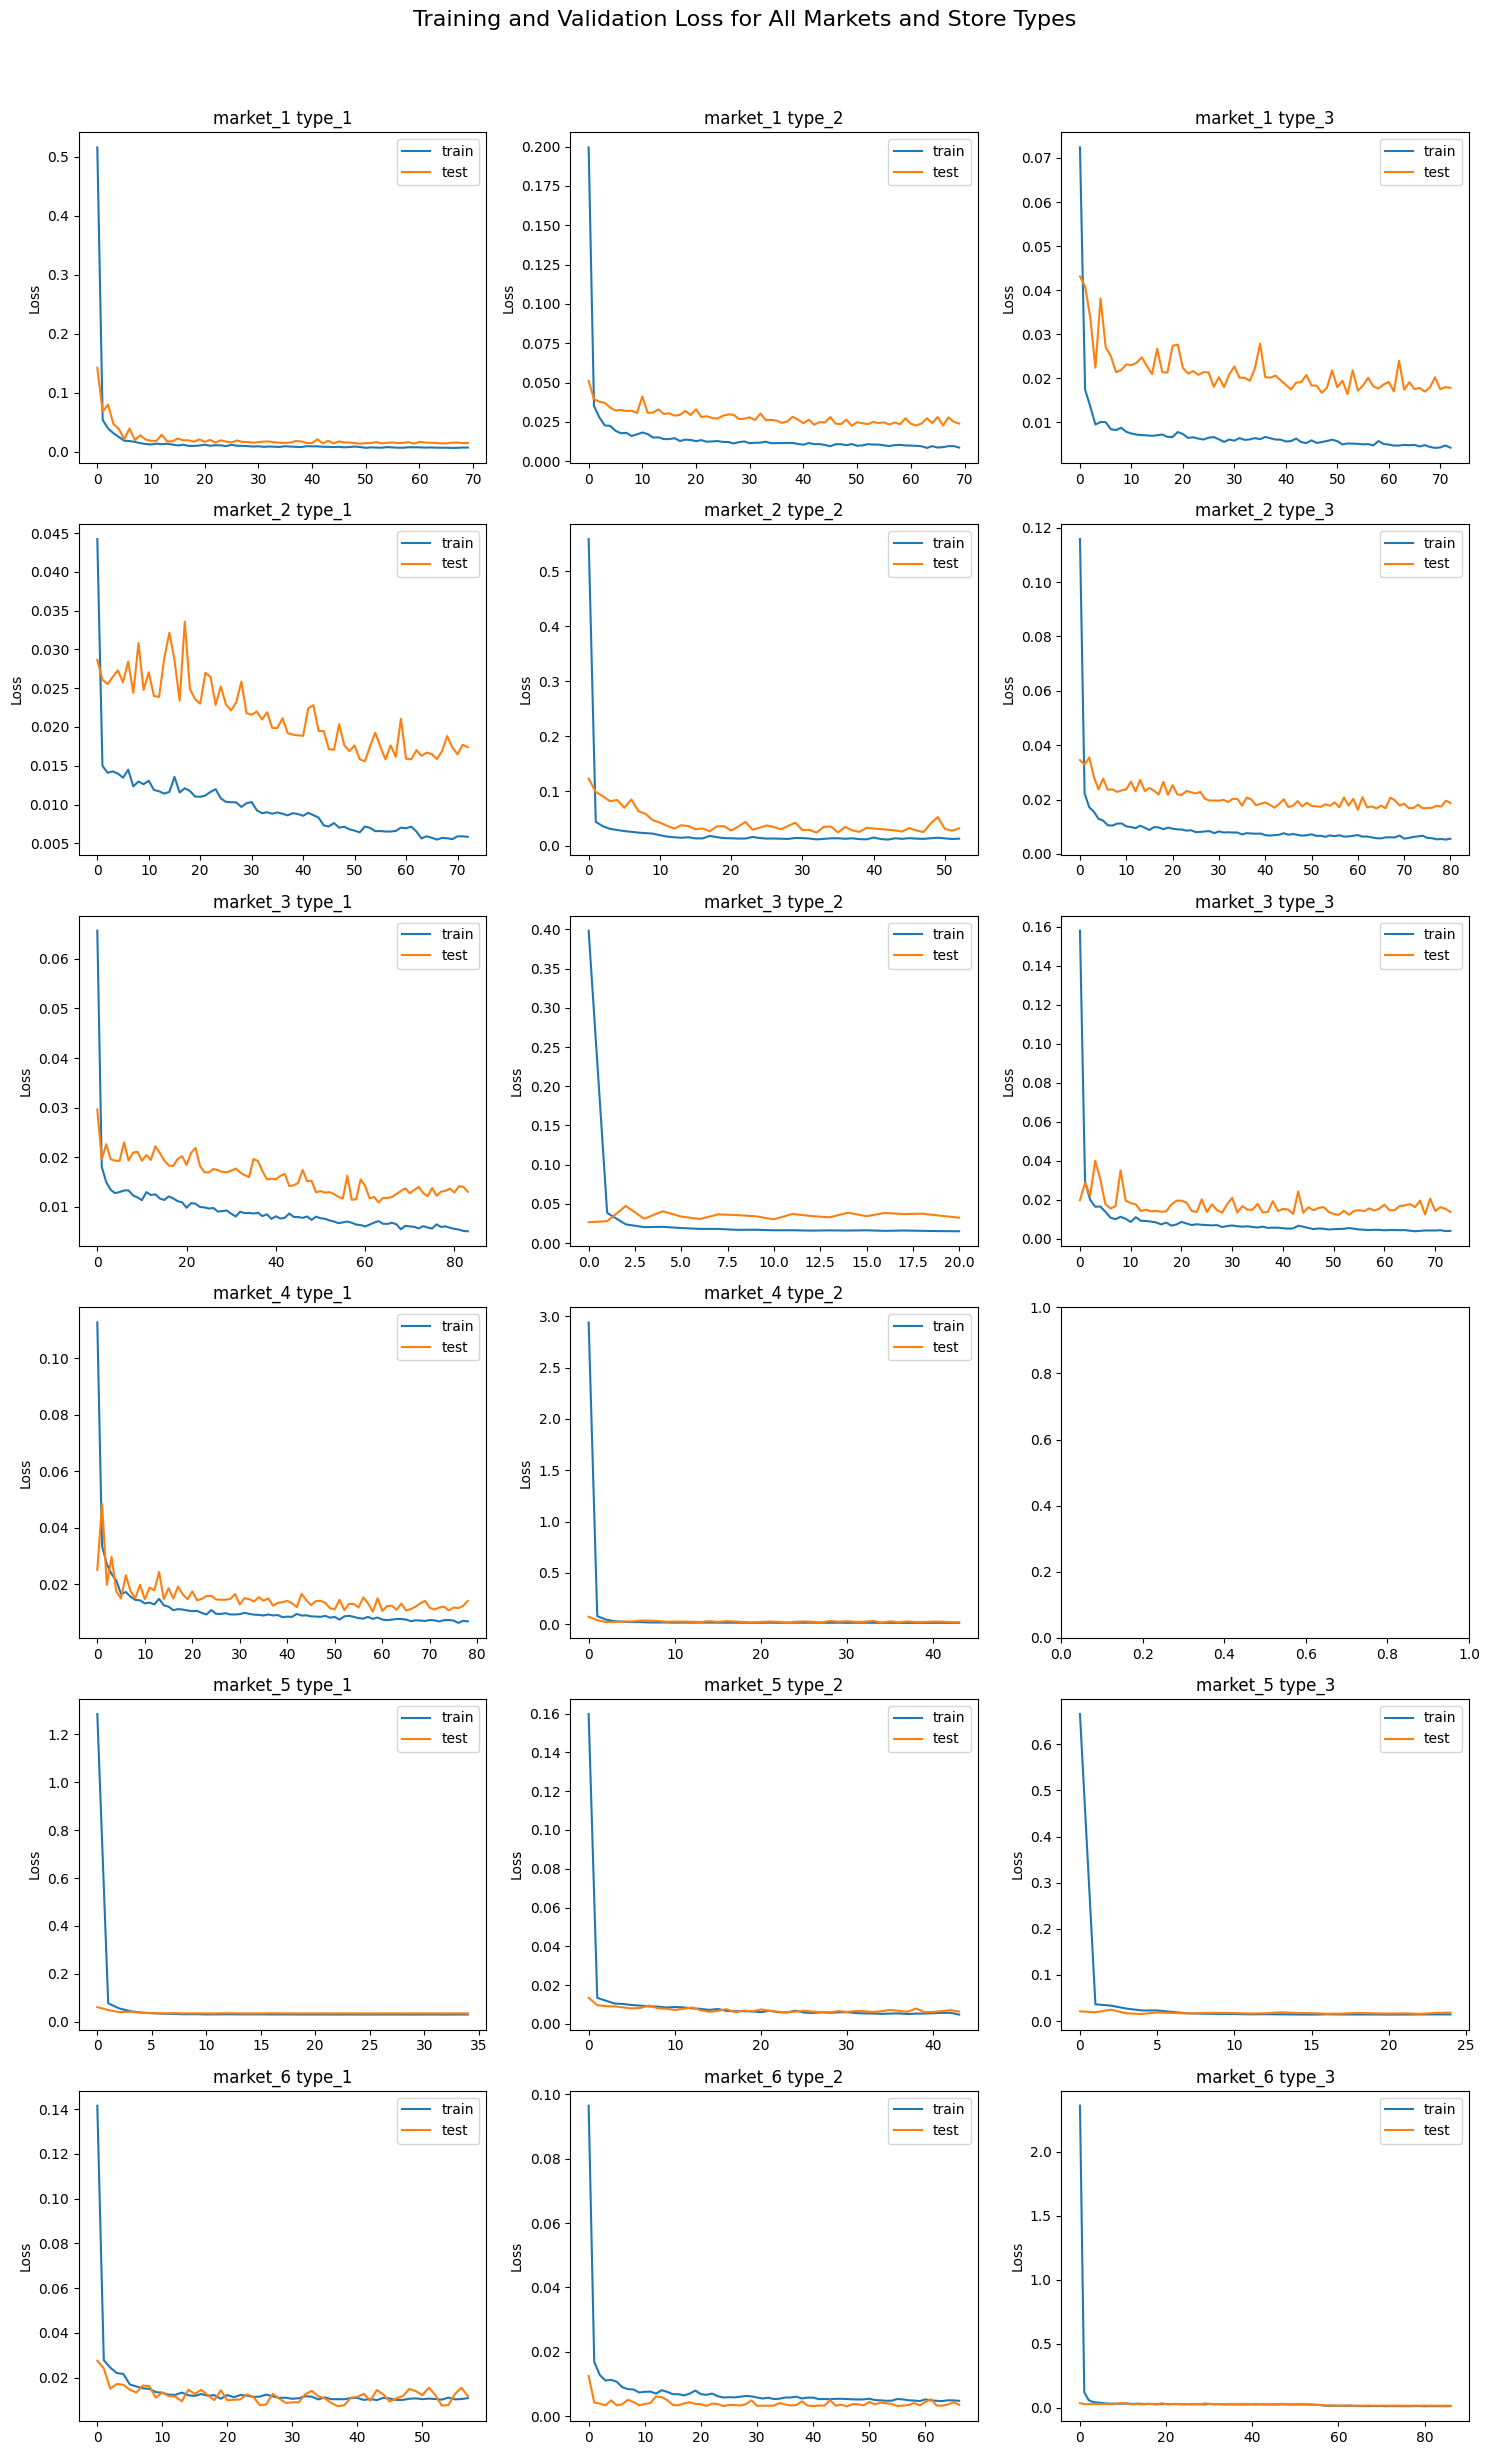

In [16]:
fig, axs = plt.subplots(len(markets), 3, figsize=(15, 25))

for i, df_name in enumerate(markets):
    for j, store_type in enumerate(['type_1', 'type_2', 'type_3']):
        store = f'{df_name}_{store_type}'
        if store in histories:
            history = histories[store]
            axs[i, j].plot(history.history['loss'], label='train')
            axs[i, j].plot(history.history['val_loss'], label='test')
            axs[i, j].set_title(f'{df_name} {store_type}')
            axs[i, j].set_ylabel('Loss')
            axs[i, j].legend()

# Añadir un título general a la figura
fig.suptitle('Training and Validation Loss for All Markets and Store Types', fontsize=16)

# Ajustar el layout de la figura y guardar
fig.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar para dejar espacio para el título
fig.savefig('figs/loss_all_markets.png')
plt.show()